Import torch stuff, matplotlib, tqdm, and the model.

In [1]:
import torch as pt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

import matplotlib.pyplot as plt
from tqdm import tqdm

import model as mm

Make simplest dataset to test if memory even works (ODR).

In [52]:
def gen_seq(opt_num, seq_len, ind):

  seq = pt.zeros(seq_len * 2 + 1, opt_num + 1)
  seq_i = pt.full((seq_len * 2 + 1,), opt_num, dtype=pt.int64)

  for i in range(seq_len):
    factor = (opt_num) ** (seq_len - i - 1)
    seq_i[seq_len + i + 1] = ind // factor
    seq[i, seq_i[seq_len + i + 1]] = 1
    ind = ind % factor

  seq[seq_len, -1] = 1
  seq[seq_len + 1:] = seq[:seq_len]

  return seq, seq_i


class RoteDataset(Dataset):

  def __init__(self, opt_num, seq_len):

    self.opt_num = opt_num
    self.seq_len = seq_len

  def __len__(self):

    return self.opt_num ** self.seq_len

  def __getitem__(self, ind):

    input, target = gen_seq(self.opt_num, self.seq_len, ind)

    return input, target


Test dataset out for something simple.

In [53]:
#dataset = ODRDataset(3, 1, 3)
dataset = RoteDataset(4, 4)
dataloader = DataLoader(dataset)
print(f"{len(dataset)} elements")
for x, labels in dataloader:
    print(f"x:\n{x}\nlabel:\n{labels}\n")

256 elements
x:
tensor([[[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]]])
label:
tensor([[4, 4, 4, 4, 4, 0, 0, 0, 0]])

x:
tensor([[[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]])
label:
tensor([[4, 4, 4, 4, 4, 0, 0, 0, 1]])

x:
tensor([[[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.]]])
label:
tensor([[4, 4, 4, 4, 4, 0, 0, 0, 2]]

Make a training dataloader. Don't bother splitting dataset because if the model has nonfunctioning memory then it can't even overfit to begin with. Four directions and wait time in range(9). Also make the model, just 1 block, and make the criterion and optimizer.

In [334]:
DIRECTIONS = 4
SEQ_LEN = 3



#dataset = ODRDataset(DIRECTIONS, 10, 20)
dataset = RoteDataset(DIRECTIONS, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
model = mm.MoPeAModel(DIRECTIONS + 1, DIRECTIONS * SEQ_LEN * 2, DIRECTIONS + 1, DIRECTIONS, depth=1)

raw_criterion = nn.CrossEntropyLoss(reduction="none")
def criterion(outputs, labels):
    blank_label = labels.max()
    mask = (labels != blank_label) + 1e-3
    
    outputs = outputs.view(-1, outputs.shape[-1])
    labels = labels.view(-1)
    mask = mask.view(-1)
    raw_loss = raw_criterion(outputs, labels)
    loss = pt.sum(raw_loss * mask) / pt.sum(mask)
    #loss = raw_loss.mean()
    
    return loss

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
)

print(f"dataset length: {len(dataset)}\nnumber of batches: {len(dataloader)}")

dataset length: 64
number of batches: 64


Train the model now on the dataset for 100 epochs and then plot the loss graph.

100%|██████████| 100/100 [01:48<00:00,  1.09s/it, L=2.3307, ML=1.4015, TL=0.9292, lr=1e-8]   


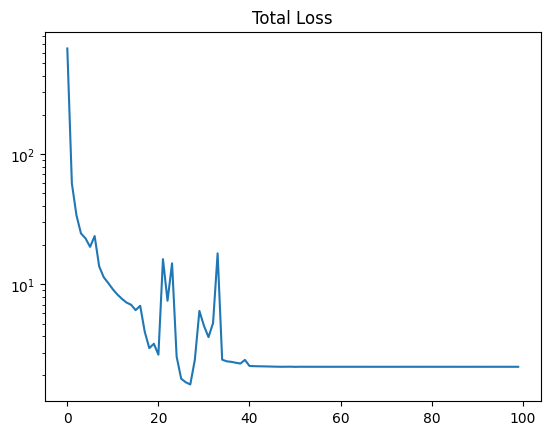

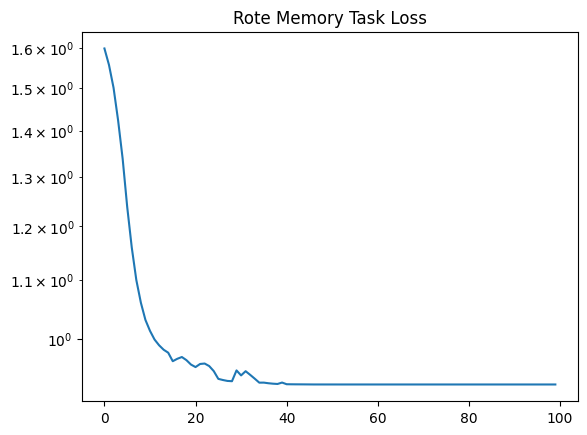

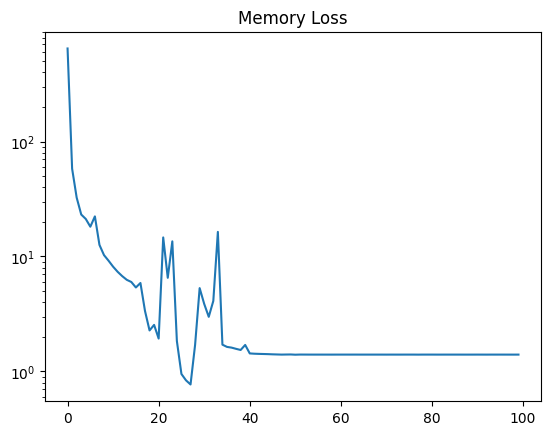

In [335]:
model.train()
losses = []
rote_losses = []
mem_losses = []
pbar = tqdm(range(100))
for epoch in pbar:
    total_loss = 0
    total_rote_loss = 0
    total_mem_loss = 0
    for x, labels in dataloader:
        optimizer.zero_grad()

        outputs, _, _, _, mem_loss, _, _, _ = model(x)

        rote_loss = criterion(outputs, labels)
        loss = rote_loss + mem_loss
        #print(loss)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_rote_loss += rote_loss.item()
        total_mem_loss += mem_loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_rote_loss = total_rote_loss / len(dataloader)
    avg_mem_loss = total_mem_loss / len(dataloader)
    losses.append(avg_loss)
    rote_losses.append(avg_rote_loss)
    mem_losses.append(avg_mem_loss)
    current_lr = optimizer.param_groups[0]['lr']
    pbar.set_postfix(L=f"{avg_loss:.4f}", TL=f"{avg_rote_loss:.4f}", ML=f"{avg_mem_loss:.4f}", lr=current_lr)

    scheduler.step(avg_loss)

pt.save(model.state_dict(), 'backup.pth')
model.eval()
print()

plt.plot(losses)
plt.title("Total Loss")
plt.yscale("log")
plt.show()

plt.plot(rote_losses)
plt.title("Rote Memory Task Loss")
plt.yscale("log")
plt.show()

plt.plot(mem_losses)
plt.title("Memory Loss")
plt.yscale("log")
plt.show()

Now to quickly test the model and manually inspect its output.

In [336]:
EXAMPLE_INDEX = -1

Sample 1/64


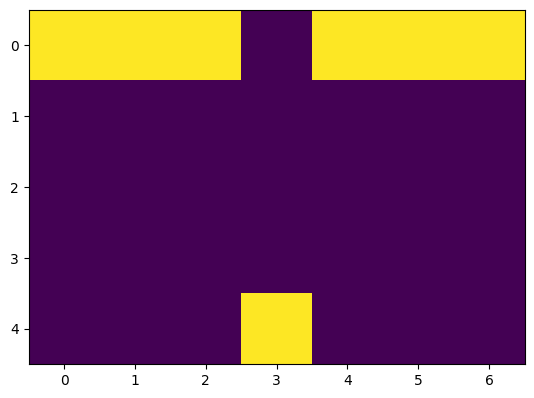

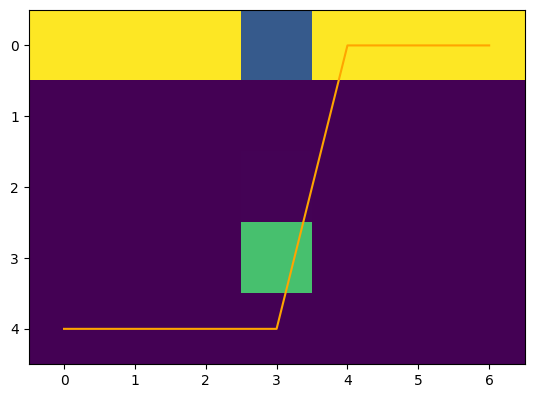

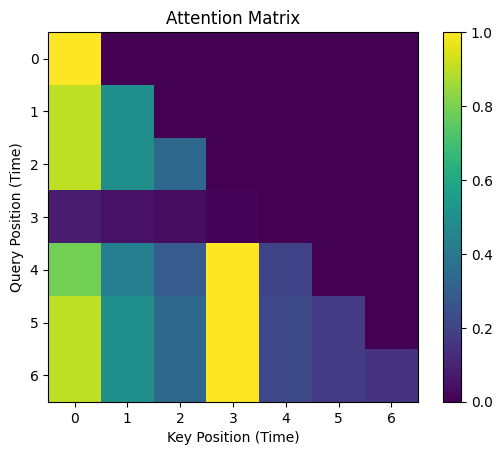

tensor([4, 4, 4, 4, 0, 0, 0])
tensor([[0.9734, 0.0072, 0.0068, 0.0064, 0.0062],
        [0.9734, 0.0069, 0.0069, 0.0065, 0.0062],
        [0.9727, 0.0066, 0.0080, 0.0066, 0.0061]], grad_fn=<IndexBackward0>)


In [337]:
#EXAMPLE_INDEX = 38
EXAMPLE_INDEX += 1
if EXAMPLE_INDEX >= len(dataset):
    EXAMPLE_INDEX = 0
print(f"Sample {EXAMPLE_INDEX + 1}/{len(dataset)}")

x, labels = dataset[EXAMPLE_INDEX]
x = x.unsqueeze(0)
labels = labels.unsqueeze(0)

model.eval()
y, _, _, _, _, q, k, v = model(x)

q_sample = q[0].detach()[0]
k_sample = k[0].detach()[0]
q_mag = pt.norm(q_sample, dim=-1, keepdim=True)
k_mag = pt.norm(k_sample, dim=-1, keepdim=True)
q_normalized = q_sample / (q_mag + 1e-8)
k_normalized = k_sample / (k_mag + 1e-8)
d_k = q_sample.shape[-1]

#scores = pt.matmul(q_sample, k_sample..T) / (d_k ** 0.5)
scores = pt.matmul(q_normalized, k_normalized.T).abs()
mask = pt.tril(pt.ones_like(scores))
#scores = scores.masked_fill(mask == 0, float('-inf'))
scores = scores.masked_fill(mask == 0, 0)
#att_matrix = pt.softmax(scores, dim=-1)
att_matrix = scores / scores.sum(dim=-1)
#att_matrix = scores

plt.imshow(x[0].T)
plt.show()

plt.imshow(y[0].detach().T)
plt.plot(labels[0], color="orange")
plt.show()

plt.imshow(att_matrix, vmin=0, vmax=1)
plt.colorbar()
plt.title("Attention Matrix")
plt.xlabel("Key Position (Time)")
plt.ylabel("Query Position (Time)")
plt.show()

print(labels[0])
print(y[0][labels[0]!=labels.max()])

In [338]:
dataset[0][1]
gen_seq(4, 2, 1)

(tensor([[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]),
 tensor([4, 4, 4, 0, 1]))

In [339]:
num_correct = 0
for sample_id in range(len(dataset)):
    x, labels = dataset[sample_id]
    x = x.unsqueeze(0)
    labels = labels.unsqueeze(0)

    model.eval()
    y, _, _, _, _, _, _, _ = model(x)
    resp_len = int(len(y[0]) / 2)
    
    num_correct += int((y[0].detach().argmax(dim=-1)[-resp_len:] == labels[0][-resp_len:]).sum())
print(f"Accuracy: {num_correct / len(dataset) / resp_len * 100:.2f}%")


Accuracy: 100.00%


Cell to load the best model. This is here so I can load the best model and then use the last two cells to evaluate it.

In [340]:
model.load_state_dict(pt.load('clean.pth'))

RuntimeError: Error(s) in loading state_dict for MoPeAModel:
	size mismatch for in_linear.weight: copying a param with shape torch.Size([16, 9]) from checkpoint, the shape in current model is torch.Size([24, 5]).
	size mismatch for in_linear.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for layer_norm1.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for layer_norm1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for layer_norm2.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for layer_norm2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for out_linear.weight: copying a param with shape torch.Size([9, 16]) from checkpoint, the shape in current model is torch.Size([5, 24]).
	size mismatch for out_linear.bias: copying a param with shape torch.Size([9]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for blocks.0.mopea_layer.layer_norm.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.0.mopea_layer.layer_norm.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.0.mopea_layer.qkv_layer.lerp_weight: copying a param with shape torch.Size([3, 16]) from checkpoint, the shape in current model is torch.Size([3, 24]).
	size mismatch for blocks.0.mopea_layer.qkv_layer.qkv_weight: copying a param with shape torch.Size([3, 8, 16]) from checkpoint, the shape in current model is torch.Size([3, 4, 24]).
	size mismatch for blocks.0.mopea_layer.r_layer.lerp_weight: copying a param with shape torch.Size([1, 16]) from checkpoint, the shape in current model is torch.Size([1, 24]).
	size mismatch for blocks.0.mopea_layer.r_layer.qkv_weight: copying a param with shape torch.Size([1, 16, 16]) from checkpoint, the shape in current model is torch.Size([1, 8, 24]).
	size mismatch for blocks.0.mopea_layer.out_linear.weight: copying a param with shape torch.Size([16, 8]) from checkpoint, the shape in current model is torch.Size([24, 4]).
	size mismatch for blocks.0.mopea_layer.out_linear.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.0.linear_block.0.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.0.linear_block.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.0.linear_block.1.weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([24, 24]).
	size mismatch for blocks.0.linear_block.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.0.linear_block.3.weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([24, 24]).
	size mismatch for blocks.0.linear_block.3.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([24]).

Since the model is able to learn the ODR task it means the model has some sort of memory capabilities, because if it didn't then it shouldn't have any information from the past states. Next is to visualize the memory matrix for a simple case. In this case two directions.